# SST-2 sentiment classification notebook

This notebook implements many of the computations for the SST-2 sentiment classification dataset. It is organized into the following sections (sections in italics are not needed for the core results):
- [**Load and process data**](#Load-and-process-data)
- [**Train final model**](#Train-final-model)
- [**Further train to obtain gold-standard attribution values**](#Further-train-to-obtain-gold-standard-attribution-values): Not part of this notebook, please see and run the script 'further_train_classification.py'
- [**Generate/load indices of left-out training instances**](#Generate/load-indices-of-left-out-training-instances)
- [**Run gradient-based TDA methods on final model**](#Run-gradient-based-TDA-methods-on-final-model): Grad-Dot, Grad-Cos, etc.
- [**Compare gradient-based methods with further training**](#Compare-gradient-based-methods-with-further-training): Produces the figures in the paper

## Import statements

In [1]:
from math import ceil
import os

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, StackDataset
from transformers import AutoModel, AutoTokenizer

/u/dwei/tda/fimo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Training
from training_LM import eval_per_sample, further_train_one_run, train_one_epoch

In [2]:
# Gradient-based TDA methods
from tqdm import tqdm
# torch-influence
from torch_influence import BaseObjective, CGInfluenceModule, LiSSAInfluenceModule
from time import time
from torch.backends.cuda import sdp_kernel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

## Load and process data

In [3]:
dataset_name = "sst2"
model_name = "bert-base-uncased"

In [17]:
dataset = datasets.load_dataset("glue", dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

Tokenize and encode data

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
sentence_key = "sentence"
max_length = 128    # longest sentence in SST-2 is 66 tokens, round up to next power of 2

def tokenize_function(examples):
    tokenized_data = tokenizer(examples[sentence_key], padding="max_length", max_length=max_length, truncation=True)
    #tokenized_data = tokenizer(examples[sentence_key], padding=True, truncation=True, return_tensors="pt")
    tokenized_data['label'] = examples['label']
    return tokenized_data


In [10]:
dataset_tokenized = dataset.map(tokenize_function, batched=True)

Map: 100%|████████████████████████████████████████████| 1821/1821 [00:00<00:00, 10447.91 examples/s]


Split into training, validation, test

In [16]:
dataset_train = dataset_tokenized["train"]
dataset_val = dataset_tokenized["validation"]
dataset_test = dataset_tokenized["test"]
dataset_train

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 67349
})

Test set is not useful here because its labels are unknown

In [17]:
torch.tensor(dataset_test["label"])

tensor([-1, -1, -1,  ..., -1, -1, -1])

Convert to Tensors and `StackDataset`

In [18]:
dataset_train_tensor = {key: torch.tensor(dataset_train[key]) for key in ["input_ids", "token_type_ids", "attention_mask", "label"]}                 
dataset_train_tensor = StackDataset(**dataset_train_tensor)

dataset_val_tensor = {key: torch.tensor(dataset_val[key]) for key in ["input_ids", "token_type_ids", "attention_mask", "label"]}                 
dataset_val_tensor = StackDataset(**dataset_val_tensor)

Save processed datasets

In [20]:
os.makedirs(os.path.join("results", dataset_name), exist_ok=True)
torch.save(dataset_train_tensor, os.path.join("results", dataset_name, "dataset_train.pt"))
torch.save(dataset_val_tensor, os.path.join("results", dataset_name, "dataset_val.pt"))

### Load processed datasets, create `DataLoader`s

In [4]:
dataset_train_tensor = torch.load(os.path.join("results", dataset_name, "dataset_train.pt"), weights_only=False)
dataset_val_tensor = torch.load(os.path.join("results", dataset_name, "dataset_val.pt"), weights_only=False)

Create `DataLoader`s, setting random seed for the training one

In [5]:
batch_size = 64    # 128 may cause CUDA out-of-memory

seed = 0
generator = torch.Generator()
generator.manual_seed(seed)
sampler = RandomSampler(dataset_train_tensor, generator=generator)
dataloader_train = DataLoader(dataset_train_tensor, batch_size=batch_size, sampler=sampler)

dataloader_val = DataLoader(dataset_val_tensor, batch_size=batch_size, sampler=SequentialSampler(dataset_val_tensor))

[[back to top]](#SST-2-sentiment-classification-notebook)

## Train final model

### Create model

BERT encoder with classification head

In [7]:
n_classes = 2

class Model(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.model.config.hidden_size, n_classes)

    def forward(self, input_dict):
        last_hidden_state = self.model(**input_dict)[0]
        cls_output = last_hidden_state[:, 0]
        logits = self.classifier(cls_output)
        return logits


Set random seed before initializing model

In [9]:
seed = 0
torch.manual_seed(seed)
model = Model(model_name).to(device)

### Train and save model

Check validation loss and accuracy of initial model

In [10]:
loss_fn_per_sample = nn.CrossEntropyLoss(reduction="none")

In [11]:
val_loss_per_sample, val_pred = eval_per_sample(dataloader_val, model, loss_fn_per_sample)
val_loss_per_sample.mean()

tensor(0.6748, device='cuda:0')

In [12]:
(val_pred.cpu() == dataset_val_tensor.datasets["label"]).float().mean()

tensor(0.5791)

Set optimizer parameters and instantiate optimizer

In [22]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-5
weight_decay = 0.
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Train model and save checkpoints

In [14]:
num_epochs = 30

train_loss = torch.empty(num_epochs)
val_loss_per_sample = torch.empty((num_epochs, len(dataloader_val.dataset)), device=device)
val_pred = torch.empty((num_epochs, len(dataloader_val.dataset)), dtype=int, device=device)
val_acc = torch.empty(num_epochs)

# Iterate over epochs
for t in range(num_epochs):
    # Train on training set
    train_loss[t] = train_one_epoch(dataloader_train, model, loss_fn, optimizer)
    # Evaluate on validation set
    val_loss_per_sample[t, :], val_pred[t, :] = eval_per_sample(dataloader_val, model, loss_fn_per_sample)
    # Validation accuracy
    val_acc[t] = (val_pred[t, :].cpu() == dataset_val_tensor.datasets["label"]).float().mean()
    # Save checkpoint
    torch.save(model.state_dict(), os.path.join("results", dataset_name, f"model_epoch_{t}.pth"))

    print(f"Epoch {t}: train loss = {train_loss[t]:.6f}, validation loss = {val_loss_per_sample[t,:].mean():.6f}, validation accuracy = {val_acc[t]:.6f}")
    

100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 0: train loss = 0.230501, validation loss = 0.224057, validation accuracy = 0.920872


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.67it/s]


Epoch 1: train loss = 0.130291, validation loss = 0.265284, validation accuracy = 0.909404


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.68it/s]


Epoch 2: train loss = 0.093986, validation loss = 0.263873, validation accuracy = 0.919725


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.67it/s]


Epoch 3: train loss = 0.072840, validation loss = 0.285403, validation accuracy = 0.925459


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.67it/s]


Epoch 4: train loss = 0.057122, validation loss = 0.305538, validation accuracy = 0.924312


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.67it/s]


Epoch 5: train loss = 0.044830, validation loss = 0.334686, validation accuracy = 0.922018


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.68it/s]


Epoch 6: train loss = 0.036692, validation loss = 0.320163, validation accuracy = 0.922018


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.68it/s]


Epoch 7: train loss = 0.031698, validation loss = 0.417908, validation accuracy = 0.911697


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.67it/s]


Epoch 8: train loss = 0.025983, validation loss = 0.413036, validation accuracy = 0.913991


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.67it/s]


Epoch 9: train loss = 0.023134, validation loss = 0.417614, validation accuracy = 0.919725


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.67it/s]


Epoch 10: train loss = 0.020620, validation loss = 0.493356, validation accuracy = 0.915138


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.67it/s]


Epoch 11: train loss = 0.018430, validation loss = 0.531035, validation accuracy = 0.919725


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.67it/s]


Epoch 12: train loss = 0.016916, validation loss = 0.539808, validation accuracy = 0.913991


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.67it/s]


Epoch 13: train loss = 0.014970, validation loss = 0.517459, validation accuracy = 0.911697


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 14: train loss = 0.013245, validation loss = 0.644025, validation accuracy = 0.908257


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:48<00:00,  3.65it/s]


Epoch 15: train loss = 0.013272, validation loss = 0.644147, validation accuracy = 0.915138


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 16: train loss = 0.012121, validation loss = 0.606945, validation accuracy = 0.910550


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 17: train loss = 0.011080, validation loss = 0.568051, validation accuracy = 0.923165


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 18: train loss = 0.010707, validation loss = 0.585863, validation accuracy = 0.915138


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 19: train loss = 0.007752, validation loss = 0.625859, validation accuracy = 0.923165


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 20: train loss = 0.008178, validation loss = 0.560111, validation accuracy = 0.918578


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 21: train loss = 0.007886, validation loss = 0.566200, validation accuracy = 0.919725


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 22: train loss = 0.008619, validation loss = 0.593696, validation accuracy = 0.916284


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 23: train loss = 0.007892, validation loss = 0.620743, validation accuracy = 0.916284


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 24: train loss = 0.007257, validation loss = 0.549110, validation accuracy = 0.916284


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 25: train loss = 0.005778, validation loss = 0.561391, validation accuracy = 0.925459


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.66it/s]


Epoch 26: train loss = 0.006964, validation loss = 0.587082, validation accuracy = 0.916284


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.67it/s]


Epoch 27: train loss = 0.006758, validation loss = 0.557952, validation accuracy = 0.919725


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:47<00:00,  3.67it/s]


Epoch 28: train loss = 0.006504, validation loss = 0.536921, validation accuracy = 0.920872


100%|███████████████████████████████████████████████████████████| 1053/1053 [04:46<00:00,  3.67it/s]


Epoch 29: train loss = 0.004857, validation loss = 0.561548, validation accuracy = 0.932339


Choose the checkpoint (i.e., number of epochs) with the highest vaidation accuracy as the "final" model. For the experiments reported in the paper, that was checkpoint 18 (19 if the first checkpoint is number 1).

In [15]:
val_acc

tensor([0.9209, 0.9094, 0.9197, 0.9255, 0.9243, 0.9220, 0.9220, 0.9117, 0.9140,
        0.9197, 0.9151, 0.9197, 0.9140, 0.9117, 0.9083, 0.9151, 0.9106, 0.9232,
        0.9151, 0.9232, 0.9186, 0.9197, 0.9163, 0.9163, 0.9163, 0.9255, 0.9163,
        0.9197, 0.9209, 0.9323])

In [20]:
best_epoch = val_acc.argmax().item()
best_epoch

29

In [24]:
os.symlink(f"model_epoch_{best_epoch}.pth", os.path.join("results", dataset_name, "model_final.pth"))

### Load trained final model

In [9]:
model = Model(model_name).to(device)
model.load_state_dict(torch.load(os.path.join("results", dataset_name, "model_final.pth")))

<All keys matched successfully>

Check validation loss and accuracy of final model

In [12]:
val_loss_per_sample, val_pred = eval_per_sample(dataloader_val, model, loss_fn_per_sample)
val_loss_per_sample.mean()

tensor(0.5615, device='cuda:0')

In [13]:
(val_pred.cpu() == dataset_val_tensor.datasets["label"]).float().mean()

tensor(0.9323)

[[back to top]](#SST-2-sentiment-classification-notebook)

## Further train to obtain gold-standard attribution values

Please see and run the script 'further_train_sst2.py'.

[[back to top]](#SST-2-sentiment-classification-notebook)

## Generate/load indices of left-out training instances

Number of training instances to leave out

In [15]:
num_leave_out = 50

Select instances to leave out randomly

In [16]:
seed = 0
rng = np.random.default_rng(seed)
ind_leave_out0 = rng.choice(len(dataset_train_tensor), num_leave_out)
ind_leave_out0 = np.sort(ind_leave_out0)
ind_leave_out0

array([  184,   360,   557,  1113,  1488,  1907,  2261,  2759,  5067,
        5414,  6013,  8370, 11804, 11830, 17328, 18169, 18679, 20185,
       20732, 26545, 27157, 28467, 32399, 33918, 34424, 35399, 36466,
       36612, 37332, 37709, 40856, 41445, 42582, 42898, 43587, 43737,
       45165, 45182, 49130, 49141, 51514, 54772, 54946, 57015, 57288,
       57745, 58134, 61473, 62976, 65378])

Save indices

In [16]:
torch.save(torch.from_numpy(ind_leave_out0), os.path.join("results", dataset_name, "ind_leave_out.pt"))

Load indices of left-out training instances

In [23]:
ind_leave_out = torch.load(os.path.join("results", dataset_name, "ind_leave_out.pt"))
# (ind_leave_out == ind_leave_out0).all()

[[back to top]](#SST-2-sentiment-classification-notebook)

## Run gradient-based TDA methods on final model

### Compute per-sample gradients of trained model

The tabular data notebooks use functions from `torch.func` to compute per-sample gradients. However, we did not succeed in using `torch.func` (in particular `torch.func.vmap`) on the BERT model here. Instead, we use a plain PyTorch implementation, adapted from https://pytorch.org/functorch/stable/notebooks/per_sample_grads.html, to define a function `compute_sample_grads` for computing per-sample gradients.

Have to exclude the following pooling layers from `torch.autograd.grad` because they are unused

In [19]:
[k for k, v in model.named_parameters() if "pooler" in k]

['model.pooler.dense.weight', 'model.pooler.dense.bias']

In [23]:
def compute_grad(input_dict):
    # Separate label and make into batches of 1
    label = input_dict.pop("label")
    label = label.unsqueeze(0).to(device)
    for key in input_dict.keys():
        input_dict[key] = input_dict[key].unsqueeze(0).to(device)

    # Compute prediction and loss
    prediction = model(input_dict)
    loss = loss_fn(prediction, label)

    # Compute gradient w.r.t. all used parameters (pooler is not used)
    return torch.autograd.grad(loss, [param for name, param in model.named_parameters() if "pooler" not in name])

def compute_sample_grads(dataset, indices):
    """ manually process each sample with per sample gradient """
    sample_grads = [compute_grad(dataset[i]) for i in indices]
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]
    sample_grads = [sample_grad.detach() for sample_grad in sample_grads]
    return sample_grads


### Compute gradient similarity (Grad-Dot, Grad-Cos)

Compute gradient similarity between left-out training instances and first `num_inst_eval` validation instances (the chosen subset of the validation set)

In [27]:
num_inst_eval = 100

In [28]:
ind_leave_out = torch.load(os.path.join("results", dataset_name, "ind_leave_out.pt"))
ind_leave_out

tensor([  184,   360,   557,  1113,  1488,  1907,  2261,  2759,  5067,  5414,
         6013,  8370, 11804, 11830, 17328, 18169, 18679, 20185, 20732, 26545,
        27157, 28467, 32399, 33918, 34424, 35399, 36466, 36612, 37332, 37709,
        40856, 41445, 42582, 42898, 43587, 43737, 45165, 45182, 49130, 49141,
        51514, 54772, 54946, 57015, 57288, 57745, 58134, 61473, 62976, 65378])

In [29]:
grad_dot = torch.zeros((num_inst_eval, num_leave_out), device=device)
grads_train_norm = torch.zeros(num_leave_out, device=device)
grads_val_norm = torch.zeros(num_inst_eval, device=device)
grad_dot.shape

torch.Size([100, 50])

Process training and validation gradients in blocks to fit in GPU memory

In [30]:
block_size = 10
num_blocks_train = ceil(num_leave_out / block_size)
num_blocks_val = ceil(num_inst_eval / block_size)
num_blocks_train, num_blocks_val

(5, 10)

Compute gradients, their inner products, and norms

In [31]:
# Iterate over training blocks
for blk_train in range(num_blocks_train):
    print(f"training block {blk_train}")
    # Indices of training block
    ind_train = range(blk_train * block_size, (blk_train + 1) * block_size)
    
    # Compute gradients for current training block
    grads_train = compute_sample_grads(dataset_train_tensor, ind_leave_out[ind_train])
    
    # Iterate over validation blocks
    for blk_val in tqdm(range(num_blocks_val)):
        # Indices of validation block
        ind_val = range(blk_val * block_size, (blk_val + 1) * block_size)

        # Compute gradients for current validation block
        grads_val = compute_sample_grads(dataset_val_tensor, ind_val)

        # Iterate over model layers
        for l in range(len(grads_train)):
            # Inner product over all dimensions corresponding to parameters
            num_dims = grads_train[l].dim()
            grad_dot[blk_val*block_size:(blk_val+1)*block_size, blk_train*block_size:(blk_train+1)*block_size] += torch.tensordot(grads_val[l], grads_train[l], dims=(list(range(1, num_dims)),) * 2)
            grads_train_norm[ind_train] += (grads_train[l] ** 2).sum(dim=list(range(1, num_dims)))
            grads_val_norm[ind_val] += (grads_val[l] ** 2).sum(dim=list(range(1, num_dims)))

        del grads_val
        torch.cuda.empty_cache()

    del grads_train
    torch.cuda.empty_cache()

grads_train_norm = torch.sqrt(grads_train_norm)
grads_val_norm = torch.sqrt(grads_val_norm)

grad_dot

training block 0


100%|███████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]


training block 1


100%|███████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


training block 2


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.28it/s]


training block 3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.28it/s]


training block 4


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.27it/s]


tensor([[ 3.8590e-09,  1.0505e-08,  1.2584e-08,  ...,  4.5012e-09,
          3.6923e-09,  1.0708e-08],
        [ 4.7487e-09,  2.3993e-08,  1.2719e-08,  ...,  5.4714e-09,
          4.7518e-09,  1.1697e-08],
        [ 1.6169e-08,  3.8078e-08,  8.3747e-08,  ...,  1.9371e-08,
          1.4294e-08,  7.1536e-08],
        ...,
        [ 1.0704e-03, -1.4094e-03,  1.8626e-02,  ...,  1.4864e-03,
          3.7455e-04,  1.7466e-02],
        [ 4.7666e-09,  2.6485e-08,  1.3100e-08,  ...,  5.4475e-09,
          4.7244e-09,  1.1849e-08],
        [ 1.2286e-08,  7.4950e-08,  2.9468e-08,  ...,  1.4053e-08,
          1.2549e-08,  2.4058e-08]], device='cuda:0')

Normalized inner products ("Grad-Cos")

In [32]:
grad_cos = grad_dot / grads_train_norm / grads_val_norm.unsqueeze(1)
grad_cos

tensor([[ 0.1299,  0.0470,  0.0857,  ...,  0.1303,  0.1282,  0.0674],
        [ 0.0836,  0.0562,  0.0453,  ...,  0.0828,  0.0863,  0.0385],
        [ 0.0645,  0.0202,  0.0676,  ...,  0.0665,  0.0588,  0.0534],
        ...,
        [ 0.0035, -0.0006,  0.0123,  ...,  0.0042,  0.0013,  0.0107],
        [ 0.0852,  0.0630,  0.0474,  ...,  0.0838,  0.0872,  0.0396],
        [ 0.0565,  0.0458,  0.0274,  ...,  0.0555,  0.0595,  0.0207]],
       device='cuda:0')

In [33]:
grad_cos.min(), grad_cos.max()

(tensor(-0.0664, device='cuda:0'), tensor(0.1356, device='cuda:0'))

In [62]:
torch.save(grad_dot, os.path.join("results", dataset_name, "grad_dot.pt"))
torch.save(grad_cos, os.path.join("results", dataset_name, "grad_cos.pt"))

### DataInf

The computation of DataInf requires an average over all training instances. We approximate this by an average over a random subsample of size 1000, where the subsample includes all the left-out training instances. The following cells define the subsample.

In [34]:
num_train_datainf = 1000

In [35]:
seed = 0
rng = np.random.default_rng(seed)
# Randomly select from not-left-out training instances
ind_train_datainf = rng.choice(np.setdiff1d(np.arange(len(dataset_train_tensor)), ind_leave_out), num_train_datainf - num_leave_out, replace=False)
ind_train_datainf = np.union1d(ind_train_datainf, ind_leave_out)
print(ind_train_datainf.shape)
ind_train_datainf[:100]

(1000,)


array([  20,  181,  184,  237,  330,  356,  359,  360,  429,  537,  547,
        552,  557,  666,  817,  940,  974,  981, 1067, 1089, 1099, 1113,
       1204, 1401, 1471, 1488, 1614, 1640, 1717, 1846, 1876, 1885, 1893,
       1907, 2235, 2261, 2287, 2398, 2470, 2679, 2699, 2703, 2725, 2732,
       2759, 2785, 2878, 2886, 2895, 3161, 3179, 3233, 3239, 3254, 3321,
       3465, 3568, 3716, 3773, 3900, 3972, 4021, 4073, 4207, 4272, 4371,
       4373, 4408, 4448, 4545, 4557, 4705, 4832, 4853, 4881, 4921, 4943,
       4950, 5000, 5063, 5067, 5178, 5250, 5278, 5346, 5414, 5479, 5489,
       5566, 5592, 5654, 5772, 5814, 5830, 5855, 5857, 5871, 5937, 5945,
       6013])

Initialize Tensors for gradient inner products: between validation and left-out training instances (LOO), between validation and "training" (the subsample of size 1000), and between LOO and "training"

In [36]:
num_layers = len(list(param for name, param in model.named_parameters() if "pooler" not in name))
num_layers

199

In [37]:
grad_dot_val_loo = torch.zeros((num_layers, num_inst_eval, num_leave_out), device=device)
grad_dot_val_train = torch.zeros((num_layers, num_inst_eval, num_train_datainf), device=device)
grad_dot_train_loo = torch.zeros((num_layers, num_train_datainf, num_leave_out), device=device)
grads_train_norm = torch.zeros(num_layers, num_train_datainf, device=device)
grad_dot_val_train.shape

torch.Size([199, 100, 1000])

Process training and validation gradients in blocks to fit in GPU memory

In [38]:
block_size = 10
num_blocks_train = ceil(num_train_datainf / block_size)
num_blocks_loo = ceil(num_leave_out / block_size)
num_blocks_val = ceil(num_inst_eval / block_size)
num_blocks_train, num_blocks_loo, num_blocks_val

(100, 5, 10)

Compute validation-LOO inner products

In [39]:
# Iterate over validation blocks
for blk_val in range(num_blocks_val):
    print(f"validation block {blk_val}")
    # Indices of validation block
    ind_val = range(blk_val * block_size, (blk_val + 1) * block_size)
    
    # Compute gradients for current validation block
    grads_val = compute_sample_grads(dataset_val_tensor, ind_val)

    # Iterate over LOO blocks
    for blk_loo in tqdm(range(num_blocks_loo)):
        # Indices of LOO block
        ind_loo = range(blk_loo * block_size, (blk_loo + 1) * block_size)

        # Compute gradients for current LOO block
        grads_loo = compute_sample_grads(dataset_train_tensor, ind_leave_out[ind_loo])
        
        # Iterate over model layers
        for l in range(num_layers):
            # Inner product over all dimensions corresponding to parameters
            num_dims = grads_val[l].dim()
            grad_dot_val_loo[l, blk_val*block_size:(blk_val+1)*block_size, blk_loo*block_size:(blk_loo+1)*block_size] = torch.tensordot(grads_val[l], grads_loo[l], dims=(list(range(1, num_dims)),) * 2)

        del grads_loo
        torch.cuda.empty_cache()

    del grads_val
    torch.cuda.empty_cache()

(grad_dot_val_loo == 0).any()

validation block 0


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]


validation block 1


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


validation block 2


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


validation block 3


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


validation block 4


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


validation block 5


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


validation block 6


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


validation block 7


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


validation block 8


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.83it/s]


validation block 9


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


tensor(False, device='cuda:0')

Compute validation-train inner products

In [40]:
# Iterate over validation blocks
for blk_val in range(num_blocks_val):
    print(f"validation block {blk_val}")
    # Indices of validation block
    ind_val = range(blk_val * block_size, (blk_val + 1) * block_size)
    
    # Compute gradients for current validation block
    grads_val = compute_sample_grads(dataset_val_tensor, ind_val)

    # Iterate over training blocks
    for blk_train in tqdm(range(num_blocks_train)):
        # Indices of training block
        ind_train = range(blk_train * block_size, (blk_train + 1) * block_size)

        # Compute gradients for current training block
        grads_train = compute_sample_grads(dataset_train_tensor, ind_train_datainf[ind_train])
        
        # Iterate over model layers
        for l in range(num_layers):
            # Inner product over all dimensions corresponding to parameters
            num_dims = grads_val[l].dim()
            grad_dot_val_train[l, blk_val*block_size:(blk_val+1)*block_size, blk_train*block_size:(blk_train+1)*block_size] = torch.tensordot(grads_val[l], grads_train[l], dims=(list(range(1, num_dims)),) * 2)

        del grads_train
        torch.cuda.empty_cache()

    del grads_val
    torch.cuda.empty_cache()

(grad_dot_val_train == 0).any()

validation block 0


100%|█████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


validation block 1


100%|█████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


validation block 2


100%|█████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]


validation block 3


100%|█████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.38it/s]


validation block 4


100%|█████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


validation block 5


100%|█████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


validation block 6


100%|█████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


validation block 7


100%|█████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


validation block 8


100%|█████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


validation block 9


100%|█████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


tensor(False, device='cuda:0')

Compute train-LOO inner products

In [41]:
# Iterate over training blocks
for blk_train in range(num_blocks_train):
    print(f"training block {blk_train}")
    # Indices of training block
    ind_train = range(blk_train * block_size, (blk_train + 1) * block_size)
    
    # Compute gradients for current training block
    grads_train = compute_sample_grads(dataset_train_tensor, ind_train_datainf[ind_train])

    # Iterate over layers
    for l in range(num_layers):
        num_dims = grads_train[l].dim()
        # Squared norm of training gradients
        grads_train_norm[l, ind_train] = (grads_train[l] ** 2).sum(dim=list(range(1, num_dims)))

    # Iterate over LOO blocks
    for blk_loo in tqdm(range(num_blocks_loo)):
        # Indices of LOO block
        ind_loo = range(blk_loo * block_size, (blk_loo + 1) * block_size)

        # Compute gradients for current LOO block
        grads_loo = compute_sample_grads(dataset_train_tensor, ind_leave_out[ind_loo])
        
        # Iterate over model layers
        for l in range(num_layers):
            # Inner product over all dimensions corresponding to parameters
            num_dims = grads_train[l].dim()
            grad_dot_train_loo[l, blk_train*block_size:(blk_train+1)*block_size, blk_loo*block_size:(blk_loo+1)*block_size] = torch.tensordot(grads_train[l], grads_loo[l], dims=(list(range(1, num_dims)),) * 2)

        del grads_loo
        torch.cuda.empty_cache()

    del grads_train
    torch.cuda.empty_cache()

print((grads_train_norm == 0).any())
(grad_dot_train_loo == 0).any()

training block 0


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


training block 1


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


training block 2


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


training block 3


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 4


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


training block 5


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


training block 6


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


training block 7


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


training block 8


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


training block 9


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


training block 10


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


training block 11


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


training block 12


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


training block 13


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


training block 14


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]


training block 15


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


training block 16


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 17


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


training block 18


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


training block 19


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


training block 20


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


training block 21


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


training block 22


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 23


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


training block 24


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


training block 25


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


training block 26


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


training block 27


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]


training block 28


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


training block 29


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


training block 30


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


training block 31


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.62it/s]


training block 32


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


training block 33


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


training block 34


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


training block 35


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 36


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 37


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


training block 38


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


training block 39


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


training block 40


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


training block 41


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


training block 42


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


training block 43


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


training block 44


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


training block 45


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


training block 46


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


training block 47


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


training block 48


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


training block 49


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


training block 50


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


training block 51


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


training block 52


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 53


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


training block 54


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


training block 55


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


training block 56


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


training block 57


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


training block 58


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


training block 59


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


training block 60


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


training block 61


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


training block 62


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


training block 63


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 64


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


training block 65


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


training block 66


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


training block 67


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


training block 68


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.63it/s]


training block 69


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


training block 70


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


training block 71


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


training block 72


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 73


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 74


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


training block 75


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


training block 76


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


training block 77


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


training block 78


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


training block 79


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


training block 80


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


training block 81


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


training block 82


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


training block 83


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


training block 84


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


training block 85


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


training block 86


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


training block 87


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 88


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


training block 89


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


training block 90


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 91


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


training block 92


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.66it/s]


training block 93


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


training block 94


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


training block 95


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


training block 96


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


training block 97


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


training block 98


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


training block 99


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]

tensor(False, device='cuda:0')


tensor(False, device='cuda:0')

Compute layer-wise damping values

In [42]:
num_params_layer = torch.tensor([param.numel() for name, param in model.named_parameters() if "pooler" not in name])
num_params_layer.sum()

tensor(108893186)

In [43]:
lambda_layer = 0.1 * grads_train_norm.mean(dim=1) / num_params_layer.to(device)

Compute DataInf values

In [45]:
# Start with last term (negated) in eq. (5) of Kwon et al. (2024)
datainf = grad_dot_val_loo.clone()
# Subtract the term involving summation over i
datainf -= torch.matmul(grad_dot_val_train / (lambda_layer.unsqueeze(1) + grads_train_norm).unsqueeze(1), grad_dot_train_loo) / num_train_datainf
# Weighted sum over layers l
datainf = (datainf / lambda_layer.unsqueeze(1).unsqueeze(2)).sum(dim=0)
datainf

tensor([[ 4.7811e+04,  2.9547e+03,  1.5360e+05,  ...,  5.6744e+04,
          4.3506e+04,  1.2015e+05],
        [ 1.0670e+03,  2.8425e+05,  3.4860e+02,  ...,  1.2856e+03,
          1.2955e+03,  2.3791e+03],
        [ 1.9131e+05,  1.6377e+04,  1.0887e+06,  ...,  2.4027e+05,
          1.5992e+05,  8.2409e+05],
        ...,
        [ 3.9701e+09, -2.4141e+10,  7.1727e+10,  ...,  3.8355e+09,
          8.8380e+08,  6.7917e+10],
        [ 8.6890e+02,  3.6016e+05,  2.6627e+02,  ...,  9.3991e+02,
          5.6149e+02,  2.1866e+03],
        [ 7.5347e+02,  1.0547e+06, -1.8675e+04,  ...,  4.7401e+02,
          1.5808e+03, -2.5008e+04]], device='cuda:0')

In [39]:
torch.save(datainf, os.path.join("results", dataset_name, "datainf.pt"))

### torch-influence methods

Among the torch-influence methods (CG, LiSSA with Gauss-Newton Hessian, LiSSA with true Hessian), we were able to run only LiSSA with Gauss-Newton Hessian (referred to simply as "LiSSA") on the BERT model. Please see and run the script 'lissa_sst2.py' for the full version of this. This subsection of the notebook is only for testing CG and LiSSA on a single validation instance (the former to see how slow CG is, the latter to check that LiSSA converges).

Disable gradient for unused pooling layers to avoid errors

In [46]:
for name, param in model.named_parameters():
    if "pooler" in name:
        param.requires_grad = False

Class that defines training and test losses

In [47]:
class CrossEntropyObjective(BaseObjective):

    def train_outputs(self, model, batch):
        batch_copy = batch.copy()
        # Separate labels
        labels = batch_copy.pop("label")        
        return model(batch_copy)

    def train_loss_on_outputs(self, outputs, batch):
        return F.cross_entropy(outputs, batch["label"])  # mean reduction required

    def train_regularization(self, params):
        return torch.tensor(0.)

    # training loss by default taken to be 
    # train_loss_on_outputs + train_regularization

    def test_loss(self, model, params, batch):
        batch_copy = batch.copy()
        # Separate labels
        labels = batch_copy.pop("label")
        return F.cross_entropy(model(batch_copy), labels)  # no regularization in test loss

Instantiate influence modules

In [48]:
# Common parameters
dataloader_train = DataLoader(dataset_train_tensor, batch_size=batch_size, sampler=SequentialSampler(dataset_train_tensor))
damp = 0.01
gnh = True
#gnh = False
# LiSSA parameters
repeat = 1
depth = 5000
# smallest in range [10, 20, 50, 100, 150, 200, 250, 300 400 500] for which algorithm converges
scale = 500

In [49]:
CG_module = CGInfluenceModule(model=model, objective=CrossEntropyObjective(), train_loader=dataloader_train, test_loader=dataloader_val,
                              device=device, damp=damp, gnh=gnh)

In [50]:
LiSSA_module = LiSSAInfluenceModule(model=model, objective=CrossEntropyObjective(), train_loader=dataloader_train, test_loader=dataloader_val,
                                    device=device, damp=damp, gnh=gnh, repeat=repeat, depth=depth, scale=scale)

`sdp_kernel` below is a work-around from https://github.com/pytorch/pytorch/issues/117974 to deal with unimplemented double backward for `aten::_scaled_dot_product_efficient_attention`

Try CG, but it takes way too long

In [ ]:
with sdp_kernel(enable_math=True, enable_flash=False, enable_mem_efficient=False):
    t_start = time()
    CG_module.influences([1, 2, 3], [0])
    t_end = time()
    print(f"CG took {t_end - t_start} seconds")    

/u/dwei/miniforge3/envs/fimo/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Check that LiSSA converges (which also takes a long time, but not as long)

In [51]:
with sdp_kernel(enable_math=True, enable_flash=False, enable_mem_efficient=False):
    t_start = time()
    print(LiSSA_module.scale)
    print(LiSSA_module.influences([1, 2, 3], [0]))
    t_end = time()
    print(f"LiSSA took {t_end - t_start} seconds")

/u/dwei/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


500
tensor([-3.5638e-07, -1.8606e-08, -7.6568e-05])
LiSSA took 5906.333496332169 seconds


[[back to top]](#SST-2-sentiment-classification-notebook)

## Compare gradient-based methods with further training

### Load and process results

Load further training results

In [99]:
subtract_mean = True

The following cell accommodates the case where 'further_train_sst2.py' was run multiple times on different ranges of seeds, by loading and concatenating all of the results. The increment `seed_incr` can be changed as needed.

In [100]:
seed_first, seed_last, seed_incr = 0, 100, 2

# Load in batches of seed_incr random seeds
tensors_full = []
tensors_loo = []
for seed in range(seed_first, seed_last, seed_incr):
    # tensors_full.append(torch.load(os.path.join("results", dataset_name, f"val_loss_further_train_full_{seed}_{seed+seed_incr}.pt"), weights_only=True))
    # tensors_loo.append(torch.load(os.path.join("results", dataset_name, f"val_loss_further_train_loo_{seed}_{seed+seed_incr}.pt"), weights_only=True))
    tensors_full.append(torch.load(os.path.join("results", dataset_name, f"val_loss_further_train_full_{seed}_{seed+seed_incr-1}.pt"), weights_only=True))
    tensors_loo.append(torch.load(os.path.join("results", dataset_name, f"val_loss_further_train_loo_{seed}_{seed+seed_incr-1}.pt"), weights_only=True))

test_loss_further_train_full = torch.cat(tensors_full, dim=4)
test_loss_further_train_loo = torch.cat(tensors_loo, dim=4)
print(test_loss_further_train_loo.shape)

torch.Size([1, 211, 872, 50, 100])


Subtract loss due to further training on full training set. This implements eq. (17) in the paper.

In [101]:
test_loss_further_train_diff = test_loss_further_train_loo - test_loss_further_train_full
num_epochs, num_evals, _, num_leave_out, num_seeds = test_loss_further_train_diff.shape
test_loss_further_train_diff.shape

torch.Size([1, 211, 872, 50, 100])

Optionally subtract mean over left-out training instances. This implements eq. (13) in the paper. (It doesn't matter whether the previous cell was run first.)

In [102]:
if subtract_mean:
    test_loss_further_train_diff -= test_loss_further_train_diff.mean(dim=3, keepdim=True)

Load gradient-based attribution results

In [103]:
grad_dot = torch.load(os.path.join("results", dataset_name, "grad_dot.pt"), weights_only=True)
grad_cos = torch.load(os.path.join("results", dataset_name, "grad_cos.pt"), weights_only=True)
datainf = torch.load(os.path.join("results", dataset_name, "datainf.pt"), weights_only=True)

In [104]:
ekfac = torch.load(os.path.join("results", dataset_name, "ekfac.tensor"), weights_only=True).to(device)
ekfac.shape

torch.Size([872, 67349])

In [105]:
trak = np.load(os.path.join("results", dataset_name, "transposed_scores.np"))
trak = torch.from_numpy(trak).to(device)
trak.shape

torch.Size([872, 67349])

Load LiSSA results, handling the case where 'lissa_sst2.py' was run multiple times on different ranges of validation instances by loading and concatenating all of the results. The increment `inst_per_job` can be changed as needed.

In [106]:
num_inst_eval = 100
inst_per_job = 8
damp = 0.01

In [107]:
lissa = []
for inst_first in range(0, num_inst_eval, inst_per_job):
    inst_last = min(inst_first + inst_per_job - 1, num_inst_eval - 1)
    lissa.append(torch.load(os.path.join("results", dataset_name, f"lissa_damp{damp}_inst{inst_first}_{inst_last}.pt"), weights_only=True))
lissa = torch.stack(lissa).sum(dim=0)

### Examine high-influence training instances

Examine high-influence training instances (according to further training influence scores) for individual validation instances as well as the average over validation instances. This subsection supports the "SST-2" paragraph of Appendix E.2.2 in the paper.

Choose (the indices of) the validation instance and the number of steps of further training

In [108]:
ind_step = -1
ind_test = 9

In [109]:
dataset["validation"][ind_test]

{'sentence': "in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . ",
 'label': 0,
 'idx': 9}

Sort the influence scores (averaged over seeds) of training instances for this validation instance

In [110]:
test_loss_further_train_diff[0, ind_step, ind_test, :, :].mean(dim=1).sort()

torch.return_types.sort(
values=tensor([-3.7193e-09, -3.7193e-09, -3.7193e-09, -3.7193e-09, -3.7193e-09,
        -3.7193e-09, -3.7193e-09, -3.7193e-09, -3.7193e-09, -3.7193e-09,
        -3.7193e-09, -3.7193e-09, -3.7193e-09, -3.7193e-09, -3.7193e-09,
        -3.7193e-09, -3.7193e-09, -3.7193e-09, -3.7193e-09, -3.7193e-09,
        -3.7193e-09, -3.7193e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09,
        -2.5272e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09,
        -2.5272e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09,
        -2.5272e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09,
        -2.5272e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09, -2.5272e-09,
        -1.3351e-09, -1.3351e-09, -1.4306e-10,  8.2014e-09,  1.3456e-07],
       device='cuda:0'),
indices=tensor([ 0,  2,  3,  5,  8,  9, 16, 17, 18, 20, 25, 27, 29, 31, 36, 38, 41, 42,
        43, 44, 48, 49,  1,  4,  7, 10, 11, 12, 13, 14, 15, 21, 23, 24, 26, 28,
        30, 32, 33, 37, 40, 45, 46, 47, 34, 

Sort the influence scores of training instances (now averaged over seeds **and** further training steps) for this validation instance

In [111]:
test_loss_further_train_diff[0, :, ind_test, :, :].mean(dim=[0, 2]).sort()

torch.return_types.sort(
values=tensor([-2.9966e-09, -2.7819e-09, -2.7819e-09, -2.7763e-09, -2.7763e-09,
        -2.7763e-09, -2.7706e-09, -2.7706e-09, -2.7706e-09, -2.7706e-09,
        -2.7706e-09, -2.7650e-09, -2.7650e-09, -2.7650e-09, -2.7650e-09,
        -2.7650e-09, -2.7650e-09, -2.7650e-09, -2.7593e-09, -2.7537e-09,
        -2.7480e-09, -2.7480e-09, -2.7424e-09, -2.7424e-09, -2.7311e-09,
        -2.7311e-09, -2.7311e-09, -2.7141e-09, -2.7085e-09, -2.7085e-09,
        -2.7028e-09, -2.6859e-09, -2.6802e-09, -2.6802e-09, -2.6746e-09,
        -2.6746e-09, -2.6463e-09, -2.6237e-09, -2.6237e-09, -2.6181e-09,
        -2.5955e-09, -2.5898e-09, -2.5785e-09, -2.5672e-09, -2.5333e-09,
        -2.5277e-09, -2.3865e-09, -2.0475e-09,  6.5963e-09,  1.2276e-07],
       device='cuda:0'),
indices=tensor([37, 36, 38, 17, 42, 32, 43, 16, 25, 27,  0, 31,  5, 33, 41, 18, 44, 48,
        49, 34,  9, 47, 20,  2,  8, 28, 10, 13, 12, 24, 29, 30, 46, 14, 45, 15,
        11, 35, 21,  4, 40,  1, 23, 26,  7, 

Sort the influence scores of training instances (now averaged over seeds, further training steps, **and** validation instances)

In [112]:
test_loss_further_train_diff[0, :, :, :, :].mean(dim=[0, 1, 3]).sort()

torch.return_types.sort(
values=tensor([-3.5198e-06, -3.4468e-06, -3.2866e-06, -3.2794e-06, -3.2480e-06,
        -3.2061e-06, -3.2026e-06, -3.1961e-06, -3.1648e-06, -3.1550e-06,
        -3.1531e-06, -3.1331e-06, -3.1244e-06, -3.1206e-06, -3.1188e-06,
        -3.1179e-06, -3.1160e-06, -3.1125e-06, -3.1117e-06, -3.1117e-06,
        -3.1087e-06, -3.1081e-06, -3.1078e-06, -3.1000e-06, -3.0914e-06,
        -3.0898e-06, -3.0854e-06, -3.0811e-06, -3.0809e-06, -3.0792e-06,
        -3.0724e-06, -3.0714e-06, -3.0707e-06, -3.0705e-06, -3.0688e-06,
        -3.0671e-06, -3.0615e-06, -3.0613e-06, -3.0611e-06, -3.0587e-06,
        -2.9711e-06, -2.9439e-06, -2.9402e-06, -2.7381e-06, -2.2257e-06,
        -2.0984e-06, -1.5744e-06,  4.6714e-06,  4.0332e-05,  9.8008e-05],
       device='cuda:0'),
indices=tensor([ 2, 37, 29, 33, 28, 26, 44, 20,  1, 42, 41, 21, 16, 25, 10, 49,  9, 18,
        36, 30, 23, 14, 27, 38, 39, 45, 47, 15, 43, 31, 11, 32, 48, 17,  0,  5,
        12, 13, 24, 46, 34,  8,  4, 35,  3, 

The left-out training instances with indices 22 and 19 are consistently the ones with the most positive (most "helpful") influence scores. We show the input text and label for these (along with all the other left-out training instances):

In [113]:
for i in range(num_leave_out):
    print(i, dataset["train"][ind_leave_out[i].item()]["sentence"], dataset["train"][ind_leave_out[i].item()]["label"])

0 with color and depth , and rather a good time  1
1 from lynch , jeunet , and von trier while failing to find a spark of its own  0
2 a headline-fresh thriller set among orthodox jews on the west bank , joseph cedar 's time of favor manages not only to find a compelling dramatic means of addressing a complex situation , it does so without compromising that complexity .  1
3 off-beat and fanciful  1
4 inhale this gutter romancer 's secondhand material  0
5 an authentic feel  1
6 when you 're a struggling nobody  0
7 its inescapable absurdities  0
8 big stars and high production values are standard procedure  1
9 witty , whimsical feature  1
10 with an unusual protagonist ( a kilt-wearing jackson ) and subject matter , the improbable `` formula 51 '' is somewhat entertaining  1
11 the feeble examples of big-screen poke-mania that have preceded it  0
12 otherwise appalling  0
13 hate it  0
14 one of the lucky few who sought it out  1
15 is instead about as fresh as last week 's issue of 

### Compare with further training results averaged over random seeds

Total number of evaluations (further training steps at which validation losses are computed)

In [114]:
num_evals_total = num_epochs * num_evals
num_evals_total

211

Number of training steps per epoch

In [115]:
num_steps_epoch = ceil(len(dataset_train_tensor) / batch_size)
num_steps_epoch

1053

Numbers of training steps at which evaluations occur. These numbers quantify the amount of further training and form the x-axis in plots such as Figure 2(f). In our experiments, evaluations were performed at every 5th step after the first step (so starting at step 6), plus the very last step.

In [116]:
num_steps_eval = torch.cat((torch.arange(6, num_steps_epoch, 5), torch.tensor([num_steps_epoch])))
num_steps_eval

tensor([   6,   11,   16,   21,   26,   31,   36,   41,   46,   51,   56,   61,
          66,   71,   76,   81,   86,   91,   96,  101,  106,  111,  116,  121,
         126,  131,  136,  141,  146,  151,  156,  161,  166,  171,  176,  181,
         186,  191,  196,  201,  206,  211,  216,  221,  226,  231,  236,  241,
         246,  251,  256,  261,  266,  271,  276,  281,  286,  291,  296,  301,
         306,  311,  316,  321,  326,  331,  336,  341,  346,  351,  356,  361,
         366,  371,  376,  381,  386,  391,  396,  401,  406,  411,  416,  421,
         426,  431,  436,  441,  446,  451,  456,  461,  466,  471,  476,  481,
         486,  491,  496,  501,  506,  511,  516,  521,  526,  531,  536,  541,
         546,  551,  556,  561,  566,  571,  576,  581,  586,  591,  596,  601,
         606,  611,  616,  621,  626,  631,  636,  641,  646,  651,  656,  661,
         666,  671,  676,  681,  686,  691,  696,  701,  706,  711,  716,  721,
         726,  731,  736,  741,  746,  7

Initialize DataFrames

In [117]:
cos_sim_mean = pd.DataFrame(index=num_steps_eval.numpy())
cos_sim_sem = pd.DataFrame(index=num_steps_eval.numpy())

Average further training influence scores over random seeds

In [118]:
test_loss_further_train_diff_mean = test_loss_further_train_diff.mean(dim=4)

Compute cosine similarities between further training influence scores and gradient-based influence scores

In [119]:
cos_sim = F.cosine_similarity(test_loss_further_train_diff_mean[:,:,:num_inst_eval,:].view(num_evals_total, num_inst_eval, num_leave_out), grad_dot.unsqueeze(0), dim=2)
cos_sim_mean["Grad-Dot"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["Grad-Dot"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_inst_eval)

In [120]:
cos_sim = F.cosine_similarity(test_loss_further_train_diff_mean[:,:,:num_inst_eval,:].view(num_evals_total, num_inst_eval, num_leave_out), grad_cos.unsqueeze(0), dim=2)
cos_sim_mean["Grad-Cos"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["Grad-Cos"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_inst_eval)

In [121]:
cos_sim = F.cosine_similarity(test_loss_further_train_diff_mean[:,:,:num_inst_eval,:].view(num_evals_total, num_inst_eval, num_leave_out), datainf.unsqueeze(0), dim=2)
cos_sim_mean["DataInf"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["DataInf"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_inst_eval)

In [122]:
cos_sim = F.cosine_similarity(test_loss_further_train_diff_mean[:,:,:num_inst_eval,:].view(num_evals_total, num_inst_eval, num_leave_out), lissa.unsqueeze(0), dim=2)
cos_sim_mean["LiSSA"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["LiSSA"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_inst_eval)

In [123]:
cos_sim = F.cosine_similarity(test_loss_further_train_diff_mean[:,:,:num_inst_eval,:].view(num_evals_total, num_inst_eval, num_leave_out), ekfac[:num_inst_eval,ind_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["EK-FAC"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["EK-FAC"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_inst_eval)

In [124]:
cos_sim = F.cosine_similarity(test_loss_further_train_diff_mean[:,:,:num_inst_eval,:].view(num_evals_total, num_inst_eval, num_leave_out), trak[:num_inst_eval,ind_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["TRAK"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["TRAK"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_inst_eval)
cos_sim_mean

,Grad-Dot,Grad-Cos,DataInf,LiSSA,EK-FAC,TRAK
6,0.299909,0.036515,0.269190,0.070103,0.014755,0.000593
11,0.363216,0.044209,0.369916,0.070781,0.028372,0.001552
16,0.333415,0.047638,0.348476,0.071562,0.026698,0.002597
21,0.319039,0.047263,0.341571,0.050424,0.025151,0.003218
26,0.311019,0.044163,0.330752,0.063381,0.029175,0.003031
...,...,...,...,...,...,...
1036,-0.106931,0.014219,-0.069455,-0.061546,0.020969,0.003693
1041,-0.091447,0.021265,-0.062560,-0.062727,0.015251,0.002713
1046,-0.074230,0.013449,-0.043025,-0.047756,0.016497,0.002671
1051,-0.087391,0.018781,-0.056234,-0.039895,0.017031,0.001115


#### Plot

This corresponds to Figure 2(f) in the paper if `subtract_mean == True` and to Figure 5(f) if `subtract_mean == False`.

In [125]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

Ensure that each gradient-based method is always plotted with the same color

In [126]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
method_colors = pd.Series(colors[:3] + [colors[4]] + colors[6:8], index=cos_sim_mean.columns)
method_colors

Grad-Dot    #1f77b4
Grad-Cos    #ff7f0e
DataInf     #2ca02c
LiSSA       #9467bd
EK-FAC      #e377c2
TRAK        #7f7f7f
dtype: object

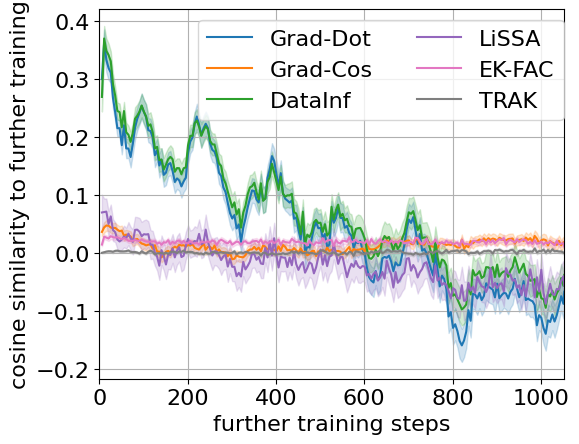

In [127]:
fig = plt.figure(figsize=(6., 4.8))
for method in cos_sim_mean.columns:
    plt.plot(cos_sim_mean[method], color=method_colors[method])
for method in cos_sim_mean.columns:
    plt.fill_between(cos_sim_mean.index, cos_sim_mean[method] - cos_sim_sem[method], cos_sim_mean[method] + cos_sim_sem[method], color=method_colors[method], alpha=0.2)
plt.xlim(0, num_steps_epoch)
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("further training steps", fontsize=fontsize)
plt.ylabel("cosine similarity to further training", fontsize=fontsize)
plt.legend(cos_sim_mean.columns, fontsize=fontsize, ncols=2, loc=(0.213, 0.7))
# plt.savefig(os.path.join("figures", f"cos_sim_epochs_{optimizer_name}{subtract_string}_{dataset_name}.pdf"), bbox_inches="tight")

#### Spearman correlation instead of cosine similarity

This section is intended to reproduce Figure 6(f) in the paper

In [128]:
from scipy.stats import spearmanr

In [129]:
spearman_mean = pd.DataFrame(index=num_steps_eval.numpy())
spearman_sem = pd.DataFrame(index=num_steps_eval.numpy())

In [130]:
spearman = np.zeros((len(num_steps_eval), num_inst_eval))
for t in range(len(num_steps_eval)):
    for i in range(num_inst_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), grad_dot[i, :].cpu()).statistic
spearman_mean["Grad-Dot"] = np.nanmean(spearman, axis=1)
spearman_sem["Grad-Dot"] = np.nanstd(spearman, axis=1) / np.sqrt((~np.isnan(spearman)).sum(axis=1))

/tmp/ipykernel_1452360/1193916318.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), grad_dot[i, :].cpu()).statistic


In [131]:
spearman = np.zeros((len(num_steps_eval), num_inst_eval))
for t in range(len(num_steps_eval)):
    for i in range(num_inst_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), grad_cos[i, :].cpu()).statistic
spearman_mean["Grad-Cos"] = np.nanmean(spearman, axis=1)
spearman_sem["Grad-Cos"] = np.nanstd(spearman, axis=1) / np.sqrt((~np.isnan(spearman)).sum(axis=1))

/tmp/ipykernel_1452360/2034418387.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), grad_cos[i, :].cpu()).statistic


In [132]:
spearman = np.zeros((len(num_steps_eval), num_inst_eval))
for t in range(len(num_steps_eval)):
    for i in range(num_inst_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), datainf[i, :].cpu()).statistic
spearman_mean["DataInf"] = np.nanmean(spearman, axis=1)
spearman_sem["DataInf"] = np.nanstd(spearman, axis=1) / np.sqrt((~np.isnan(spearman)).sum(axis=1))

/tmp/ipykernel_1452360/1471306720.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), datainf[i, :].cpu()).statistic


In [133]:
spearman = np.zeros((len(num_steps_eval), num_inst_eval))
for t in range(len(num_steps_eval)):
    for i in range(num_inst_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), lissa[i, :].cpu()).statistic
spearman_mean["LiSSA"] = np.nanmean(spearman, axis=1)
spearman_sem["LiSSA"] = np.nanstd(spearman, axis=1) / np.sqrt((~np.isnan(spearman)).sum(axis=1))

/tmp/ipykernel_1452360/1886778865.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), lissa[i, :].cpu()).statistic


In [134]:
spearman = np.zeros((len(num_steps_eval), num_inst_eval))
for t in range(len(num_steps_eval)):
    for i in range(num_inst_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), ekfac[i, ind_leave_out].cpu()).statistic
spearman_mean["EK-FAC"] = np.nanmean(spearman, axis=1)
spearman_sem["EK-FAC"] = np.nanstd(spearman, axis=1) / np.sqrt((~np.isnan(spearman)).sum(axis=1))

/tmp/ipykernel_1452360/3510892711.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), ekfac[i, ind_leave_out].cpu()).statistic


In [135]:
spearman = np.zeros((len(num_steps_eval), num_inst_eval))
for t in range(len(num_steps_eval)):
    for i in range(num_inst_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), trak[i, ind_leave_out].cpu()).statistic
spearman_mean["TRAK"] = np.nanmean(spearman, axis=1)
spearman_sem["TRAK"] = np.nanstd(spearman, axis=1) / np.sqrt((~np.isnan(spearman)).sum(axis=1))
spearman_mean

/tmp/ipykernel_1452360/3229394936.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[0, t, i, :].cpu(), trak[i, ind_leave_out].cpu()).statistic


,Grad-Dot,Grad-Cos,DataInf,LiSSA,EK-FAC,TRAK
6,0.295352,0.122726,0.349642,0.043908,0.163920,-0.007273
11,0.306022,0.144492,0.403013,0.055329,0.187962,0.009516
16,0.283135,0.145677,0.405111,0.054675,0.176085,-0.005438
21,0.271030,0.121723,0.399989,0.030469,0.177617,0.014726
26,0.312887,0.140237,0.422325,0.073263,0.183309,0.016784
...,...,...,...,...,...,...
1036,0.087697,0.036123,0.068673,0.000589,0.086769,0.028304
1041,0.056183,0.060111,0.065943,0.038502,0.066834,0.026578
1046,0.046595,0.008565,0.034262,0.007176,0.038257,0.029814
1051,0.029677,0.024303,0.027221,-0.022125,0.032604,0.026992


In [136]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

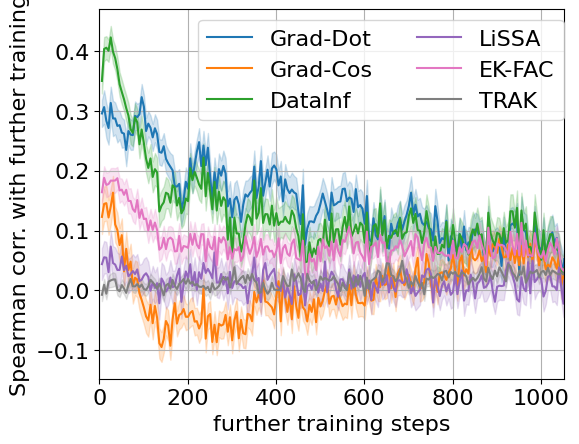

In [137]:
fig = plt.figure(figsize=(6., 4.8))
for method in spearman_mean.columns:
    plt.plot(spearman_mean[method], color=method_colors[method])
for method in spearman_mean.columns:
    plt.fill_between(spearman_mean.index, spearman_mean[method] - spearman_sem[method], spearman_mean[method] + spearman_sem[method], color=method_colors[method], alpha=0.2)
plt.xlim(0, num_steps_epoch)
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("further training steps", fontsize=fontsize)
plt.ylabel("Spearman corr. with further training", fontsize=fontsize)
plt.legend(spearman_mean.columns, fontsize=fontsize, ncols=2, loc=(0.213, 0.7))
# plt.savefig(os.path.join("figures", f"spearman_epochs_{optimizer_name}{subtract_string}_{dataset_name}.pdf"), bbox_inches="tight")


### Average further training over different numbers of random seeds

This corresponds to Figures 3(b) and 7(f) in the paper if `subtract_mean == True`, and to Figures 9(f) if `subtract_mean == False`.

In [138]:
kernel_sizes = [1, 2, 5, 10, 20, 50, 100]
num_epochs_avg = 1

cos_sim = {}
cos_sim_mean = pd.DataFrame(index=kernel_sizes)
cos_sim_sem = pd.DataFrame(index=kernel_sizes)

for k, kernel_size in enumerate(kernel_sizes):
    # Average further training results over moving windows of random seeds
    if kernel_size == 1:
        test_loss_further_train_diff_avg = test_loss_further_train_diff.clone()
    else:
        test_loss_further_train_diff_avg = F.avg_pool1d(test_loss_further_train_diff.view(-1, num_seeds), kernel_size=kernel_size).view(test_loss_further_train_diff.shape[:4] + (-1,))
    # Replace constant near-zero attribution vectors
    #test_loss_further_train_diff_avg = replace_near_zeros(test_loss_further_train_diff_avg)
    # Compute cosine similarity
    cos_sim["Grad-Dot"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), grad_dot.unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["Grad-Cos"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), grad_cos.unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["DataInf"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), datainf.unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["LiSSA"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), lissa.unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["EK-FAC"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), ekfac[:num_inst_eval,ind_leave_out].unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["TRAK"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), trak[:num_inst_eval,ind_leave_out].unsqueeze(0).unsqueeze(3), dim=2)
    for key in cos_sim.keys():
        # Aggregate over epochs
        #cos_sim[key] = cos_sim[key][:num_epochs_avg].mean(dim=0)
        #cos_sim[key] = cos_sim[key].max(dim=0).values
        #cos_sim_mean.loc[kernel_size, key] = cos_sim[key].mean().item()
        #cos_sim_sem.loc[kernel_size, key] = cos_sim[key].std().item() / np.sqrt(cos_sim[key].numel())
        cos_sim_mean.loc[kernel_size, key] = cos_sim[key].mean(dim=[1, 2]).max().item()
        step_max = cos_sim[key].mean(dim=[1, 2]).argmax()
        cos_sim_sem.loc[kernel_size, key] = cos_sim[key].std(dim=[1, 2])[step_max].item() / np.sqrt(cos_sim[key][0].numel())

cos_sim_mean
#print(cos_sim_sem)

,Grad-Dot,Grad-Cos,DataInf,LiSSA,EK-FAC,TRAK
1,0.143754,0.037879,0.145286,0.023095,0.012143,0.001562
2,0.179106,0.040803,0.179842,0.029965,0.014887,0.001885
5,0.243045,0.043318,0.241109,0.045099,0.019606,0.003193
10,0.292710,0.045196,0.292279,0.057418,0.022843,0.004488
20,0.326591,0.046050,0.328852,0.062325,0.025490,0.005228
50,0.350513,0.047720,0.356948,0.069630,0.028518,0.007411
100,0.363216,0.047638,0.369916,0.071562,0.029175,0.008085


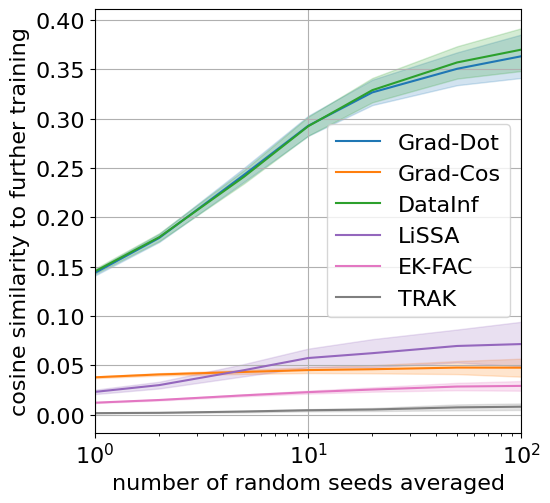

In [139]:
fig = plt.figure(figsize=(5.5, 5.5))
for method in cos_sim_mean.columns:
    plt.semilogx(cos_sim_mean[method], color=method_colors[method])
#plt.semilogx(cos_sim_mean)
for method in cos_sim_mean.columns:
    plt.fill_between(cos_sim_mean.index, cos_sim_mean[method] - cos_sim_sem[method], cos_sim_mean[method] + cos_sim_sem[method], color=method_colors[method], alpha=0.2)
plt.xlim(kernel_sizes[0], kernel_sizes[-1])
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("number of random seeds averaged", fontsize=fontsize)
plt.ylabel("cosine similarity to further training", fontsize=fontsize)
plt.legend(cos_sim_mean.columns, fontsize=fontsize)
# plt.savefig(os.path.join("figures", f"cos_sim_seeds_{optimizer_name}{subtract_string}_{dataset_name}.pdf"), bbox_inches="tight")


In [106]:
kernel_size = 100

In [100]:
if one_epoch or ckpt_18:
    cos_sim_mean = pd.DataFrame(index=num_steps_eval.numpy())
    cos_sim_sem = pd.DataFrame(index=num_steps_eval.numpy())
else:
    cos_sim_mean = pd.DataFrame(index=100 * np.arange(1, num_evals_total + 1))
    cos_sim_sem = pd.DataFrame(index=100 * np.arange(1, num_evals_total + 1))


In [114]:
# Average further training results over moving windows of random seeds
if kernel_size == 1:
    test_loss_further_train_diff_avg = test_loss_further_train_diff.clone()
else:
    test_loss_further_train_diff_avg = F.avg_pool1d(test_loss_further_train_diff.view(-1, num_seeds), kernel_size=kernel_size).view(test_loss_further_train_diff.shape[:4] + (-1,))
# Replace constant near-zero attribution vectors
#test_loss_further_train_diff_avg = replace_near_zeros(test_loss_further_train_diff_avg)
# Find near-zero attribution vectors
test_loss_further_train_diff_avg_max_abs = test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].abs().max(dim=3).values
ind_near_zero = test_loss_further_train_diff_avg_max_abs < 1e-10
ind_near_zero = ind_near_zero.squeeze()

In [108]:
hist = torch.histogram(torch.log10(test_loss_further_train_diff_avg_max_abs.cpu()), torch.arange(-18., 1.))

In [109]:
hist.hist.int(), hist.bin_edges.int()

(tensor([   0,    1,   22,  247,  126,    0,    0,    0,   51, 9891, 6229, 1136,
          853,  208,  831, 1102,  369,    0], dtype=torch.int32),
 tensor([-18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
          -4,  -3,  -2,  -1,   0], dtype=torch.int32))

In [110]:
(test_loss_further_train_diff_avg_max_abs == 0).sum()

tensor(34, device='cuda:0')

In [115]:
ind_near_zero.sum() / ind_near_zero.numel()

tensor(0.0204, device='cuda:0')

In [89]:
# Compute cosine similarity
cos_sim = {}
cos_sim["Grad-Dot"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), grad_dot.unsqueeze(0).unsqueeze(3), dim=2)
cos_sim["Grad-Cos"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), grad_cos.unsqueeze(0).unsqueeze(3), dim=2)
cos_sim["DataInf"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), datainf.unsqueeze(0).unsqueeze(3), dim=2)
cos_sim["LiSSA"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:,:num_inst_eval,:,:].view(num_evals_total, num_inst_eval, num_leave_out, -1), lissa.unsqueeze(0).unsqueeze(3), dim=2)

for key in cos_sim.keys():
    cos_sim[key][ind_near_zero] = torch.nan
    cos_sim_mean[key] = cos_sim[key].nanmean(dim=[1, 2]).cpu()
    #cos_sim_mean[key] = cos_sim[key].mean(dim=[1, 2]).cpu()
    #cos_sim_sem[key] = cos_sim.std(dim=1).cpu() / np.sqrt(num_inst_eval)

cos_sim_mean


,Grad-Dot,Grad-Cos,DataInf,LiSSA
5,0.496261,0.109964,0.432151,0.083983
10,0.483693,0.121342,0.488849,0.077707
15,0.437707,0.120822,0.456058,0.071808
20,0.391614,0.112358,0.417388,0.062851
25,0.350919,0.105092,0.381120,0.058040
...,...,...,...,...
1035,-0.027458,0.026754,0.003731,-0.034464
1040,-0.019050,0.027424,0.006717,-0.032752
1045,-0.010500,0.026463,0.014442,-0.034635
1050,-0.012528,0.028150,0.013010,-0.026521


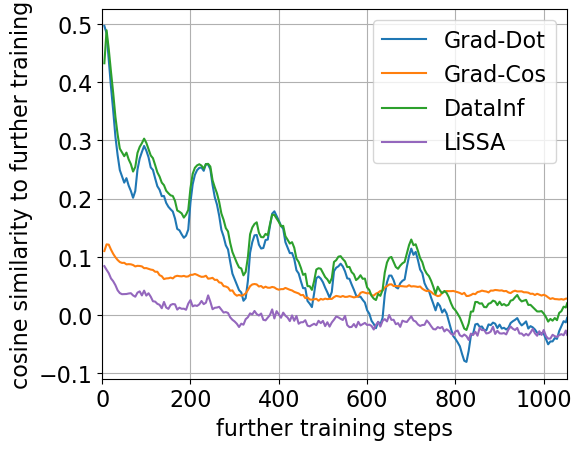

In [96]:
fig = plt.figure(figsize=(6., 4.8))
for method in cos_sim_mean.columns:
    plt.plot(cos_sim_mean[method], color=method_colors[method])
#for method in cos_sim_mean.columns:
    #plt.fill_between(cos_sim_mean.index, cos_sim_mean[method] - cos_sim_sem[method], cos_sim_mean[method] + cos_sim_sem[method], color=method_colors[method], alpha=0.2)
plt.xlim(0, num_steps_epoch)
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("further training steps", fontsize=fontsize)
plt.ylabel("cosine similarity to further training", fontsize=fontsize)
plt.legend(cos_sim_mean.columns, fontsize=fontsize)
#plt.savefig(os.path.join("figures", f"cos_sim_epochs_{optimizer_name}{subtract_string}_{dataset_name}.pdf"), bbox_inches="tight")

### Compare sorted attribution scores

This subsection was used to produce Figure 10(d) in the paper

Take the further training influence scores averaged over seeds (`test_loss_further_train_diff_mean`), sort them for each test instance, and then average the sorted scores over test instances

In [140]:
test_loss_further_train_diff_mean_sorted = test_loss_further_train_diff_mean[:,:,:num_inst_eval,:].sort(dim=3).values
test_loss_further_train_diff_mean_sorted_mean = test_loss_further_train_diff_mean_sorted.mean(dim=2).cpu()
test_loss_further_train_diff_mean_sorted_sem = test_loss_further_train_diff_mean_sorted.std(dim=2).cpu() / np.sqrt(num_inst_eval)

Compare against similarly sorted and averaged attribution scores from Grad-Dot and Grad-Cos

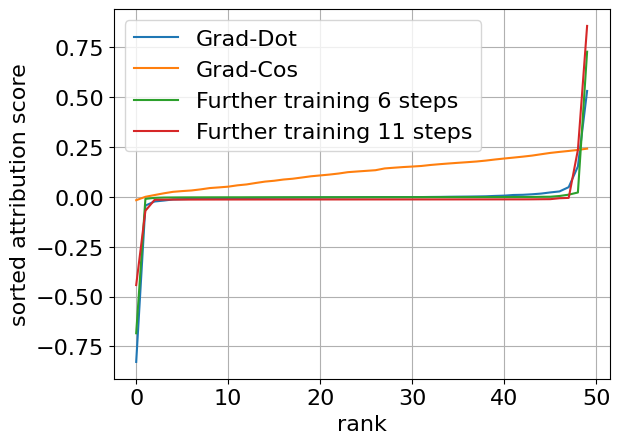

In [141]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

grad_dot_sorted_mean = grad_dot.sort(dim=1).values.mean(dim=0).cpu()
grad_cos_sorted_mean = grad_cos.sort(dim=1).values.mean(dim=0).cpu()
plt.plot(grad_dot_sorted_mean / grad_dot_sorted_mean.norm())
plt.plot(grad_cos_sorted_mean / grad_cos_sorted_mean.norm())
#epoch, step = 0, 5
epoch = 0
steps = [0, 1]
for step in steps:
#plt.plot(test_loss_further_train_diff_mean_sorted_mean[epoch,step])
    plt.plot(test_loss_further_train_diff_mean_sorted_mean[epoch,step] / test_loss_further_train_diff_mean_sorted_mean[epoch,step].norm())
#plt.fill_between(range(num_leave_out), 
#                 test_loss_further_train_diff_mean_sorted_mean[epoch,step] - test_loss_further_train_diff_mean_sorted_sem[epoch,step], 
#                 test_loss_further_train_diff_mean_sorted_mean[epoch,step] + test_loss_further_train_diff_mean_sorted_sem[epoch,step],
#                 alpha=0.15)

plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("rank", fontsize=fontsize)
plt.ylabel("sorted attribution score", fontsize=fontsize)
plt.legend(["Grad-Dot", "Grad-Cos", f"Further training {num_steps_eval[steps[0]]} steps", f"Further training {num_steps_eval[steps[1]]} steps"], fontsize=fontsize)
# plt.savefig(os.path.join("figures", f"attrib_scores_{optimizer_name}{subtract_string}_{dataset_name}.pdf"), bbox_inches="tight")


[[back to top]](#SST-2-sentiment-classification-notebook)

See whether `torch.manual_seed()` affects generator

In [118]:
generator = torch.Generator()
generator.manual_seed(0)

In [125]:
generator.get_state()

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)

In [124]:
torch.manual_seed(4)

Write shell scripts for further training jobs

In [50]:
for seed in range(50, 100, 2):
    with open(f"further_train_sst2_ckpt18_{seed}_{seed+1}.sh", "w") as f:
        f.write("#!/bin/bash\n")
        f.write("source ~/.bashrc\n")
        f.write("mamba activate fimo\n")
        f.write(f"python further_train_sst2_ckpt18.py {seed} {seed+1}\n")

In [14]:
" ".join(str(seed) for seed in range(0, 50, 2))

'0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48'

In [13]:
with open(f"further_train_sst2_ckpt18_all_jobs.sh", "w") as f:
    f.write("#!/bin/bash\n")
    f.write("\n")
    for seed in range(50, 100, 2):
        f.write(f"jbsub -mem 16g -cores 1+1 -q x86_24h -o further_train_sst2_ckpt18_{seed}_{seed+1}.out" +\
                f" -e further_train_sst2_ckpt18_{seed}_{seed+1}.err bash further_train_sst2_ckpt18_{seed}_{seed+1}.sh\n")

Write shell scripts for LiSSA jobs

In [26]:
inst_per_job = 8
damp = 0.01

In [27]:
for inst_first in range(0, num_inst_eval, inst_per_job):
    inst_last = min(inst_first + inst_per_job - 1, num_inst_eval - 1)
    with open(f"lissa_sst2_damp{damp}_{inst_first}_{inst_last}.sh", "w") as f:
        f.write("#!/bin/bash\n")
        f.write("source ~/.bashrc\n")
        f.write("mamba activate fimo\n")
        f.write(f"python lissa_sst2.py --inst_first {inst_first} --inst_last {inst_last} --damp {damp} --gnh\n") 

In [28]:
with open(f"lissa_sst2_all_jobs.sh", "w") as f:
    f.write("#!/bin/bash\n")
    f.write("\n")
    for inst_first in range(0, num_inst_eval, inst_per_job):
        inst_last = min(inst_first + inst_per_job - 1, num_inst_eval - 1)
        f.write(f"jbsub -mem 16g -cores 1+1 -q x86_24h -o lissa_sst2_damp{damp}_{inst_first}_{inst_last}.out" +\
                f" -e lissa_sst2_damp{damp}_{inst_first}_{inst_last}.err bash lissa_sst2_damp{damp}_{inst_first}_{inst_last}.sh\n")